## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

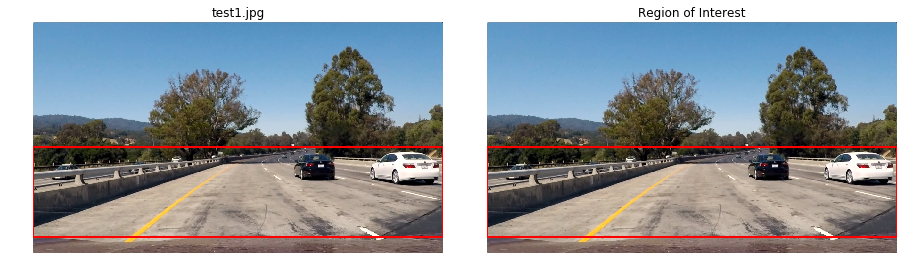

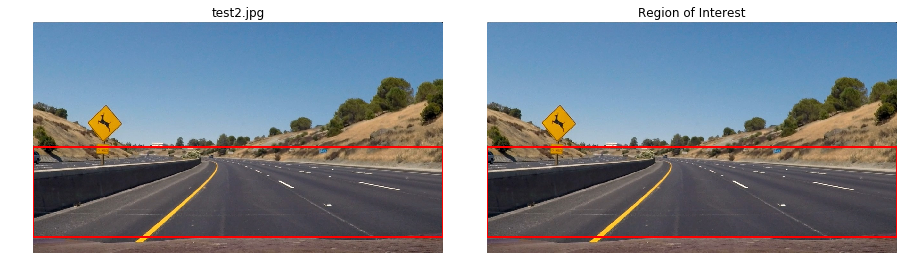

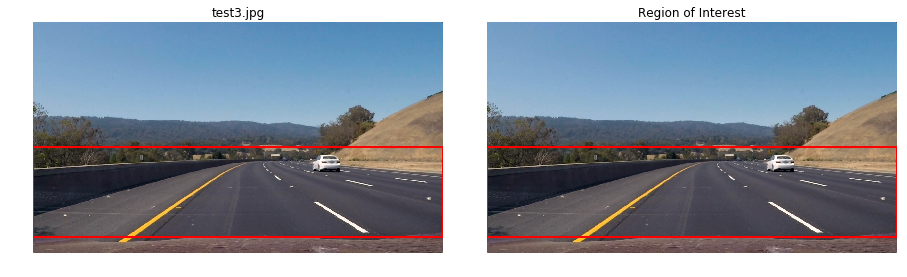

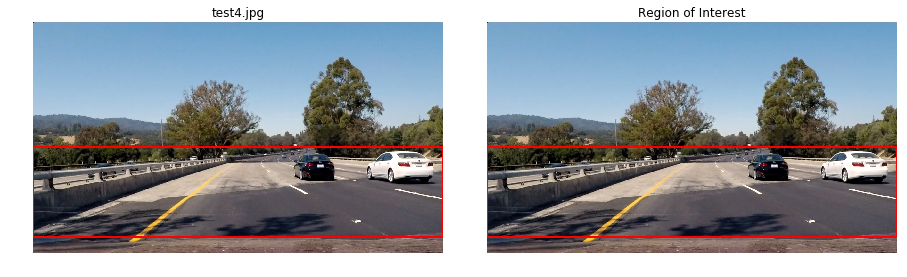

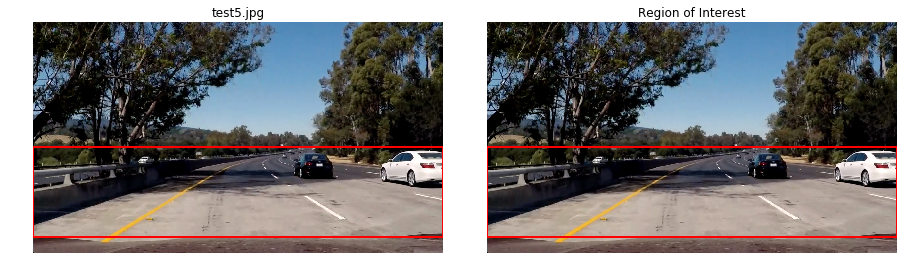

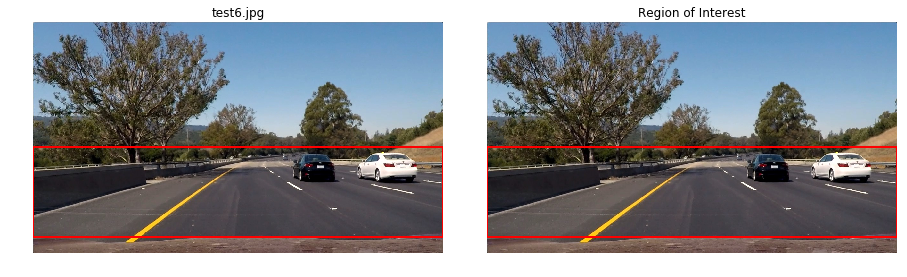

In [5]:
#importing some useful packages
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

IMAGE_SHAPE = (720,1280,3)

TEST_IMAGES_DIR = "test_images/"

Y_BEGIN = 370
Y_END = 670

for filename in os.listdir(TEST_IMAGES_DIR):
    image = mpimg.imread(TEST_IMAGES_DIR + filename)
        
    roi = cv2.rectangle(image, (0, Y_BEGIN), (IMAGE_SHAPE[1], Y_END), (255, 0, 0), 6)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,16))
    fig.tight_layout()
    ax[0].imshow(image)
    ax[0].set_title(filename)
    ax[0].set_axis_off()
    ax[1].imshow(roi)
    ax[1].set_title('Region of Interest')
    ax[1].set_axis_off()
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    plt.show()

In [29]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(image, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                     spatial_feat=True, hist_feat=True, hog_feat=True):    
        
        features = []
        # apply color conversion if other than 'RGB'
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else:
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            features.append(hog_features)
        return np.concatenate(features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_from_files(imgfiles, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                                pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                                spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgfiles:
        file_features = []
        # Read in each one by one
        img = cv2.imread(file)
        file_features = extract_features(img, color_space, spatial_size, hist_bins, orient, 
                                         pix_per_cell, cell_per_block, hog_channel, 
                                         spatial_feat, hist_feat, hog_feat)
        
        features.append(file_features)
    # Return list of feature vectors
    return features

In [41]:
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [500, 600] # Min and max in y to search in slide_window()

car_files = glob.glob("./vehicles/*/*.png")
notcar_files = glob.glob("./non-vehicles/*/*.png")

print("Preparing data {} vehicle samples {} non-vehicle samples ...".format(len(car_files), len(notcar_files)))


start = time.clock()
car_features = extract_features_from_files(car_files, color_space=color_space, spatial_size=spatial_size, 
                                           hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                           cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                           spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features_from_files(notcar_files, color_space=color_space, spatial_size=spatial_size, 
                                              hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                              cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                              spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print("{} seconds to prepare data".format(round(time.clock() - start, 2)))

print("Feature vector length: {}".format(len(X_train[0])))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
start = time.clock()
svc.fit(X_train, y_train)
print("{} seconds to train SVC".format(round(time.clock() - start, 2)))
# Check the score of the SVC
print("Test Accuracy of SVC = ", round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Preparing data 8792 vehicle samples 8968 non-vehicle samples ...
97.12 seconds to prepare data
Feature vector length: 5568
4.66 seconds to train SVC
Test Accuracy of SVC =  0.9924


In [34]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
                                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

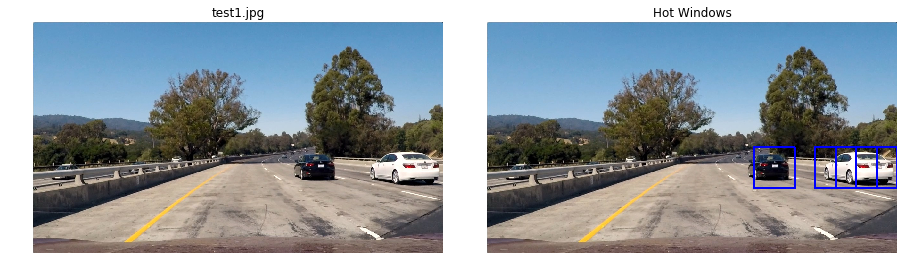

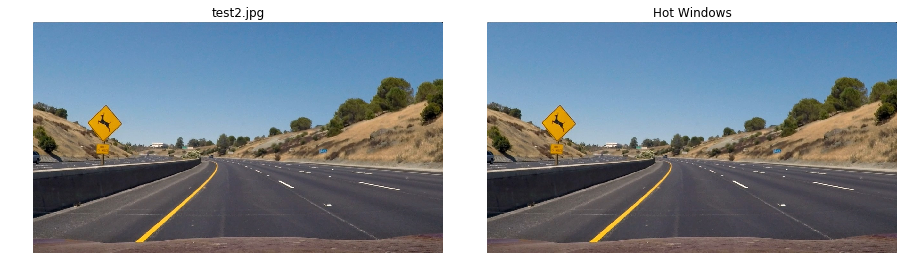

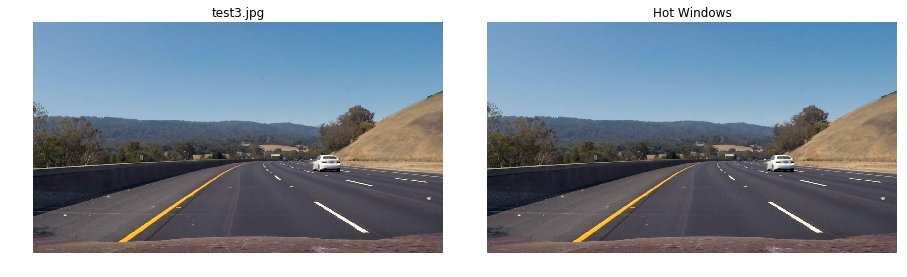

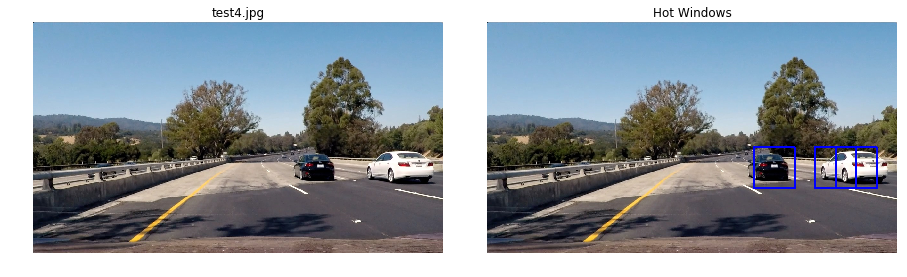

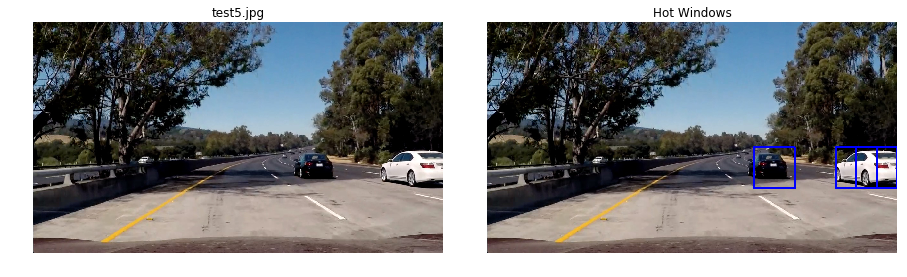

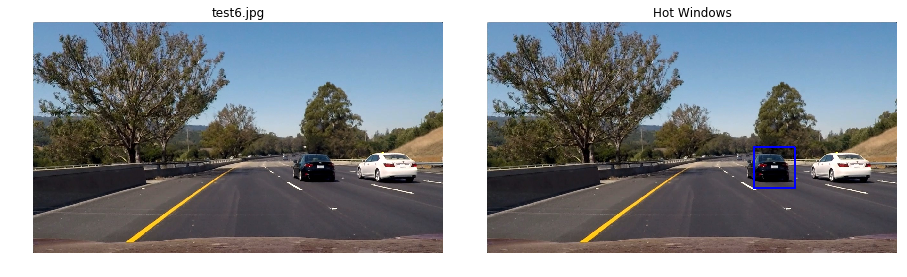

In [37]:
for filename in os.listdir(TEST_IMAGES_DIR):
    image = cv2.imread(TEST_IMAGES_DIR + filename)

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=(Y_BEGIN, Y_END), 
                           xy_window=(128, 128), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, spatial_size=spatial_size, 
                                 hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,16))
    fig.tight_layout()
    ax[0].imshow(image)
    ax[0].set_title(filename)
    ax[0].set_axis_off()
    ax[1].imshow(window_img)
    ax[1].set_title('Hot Windows')
    ax[1].set_axis_off()
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    plt.show()

In [50]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    img_tosearch = img[ystart:ystop,:,:]
    img_tosearch.astype(np.float32)/255
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HSV)
                                                                          
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows

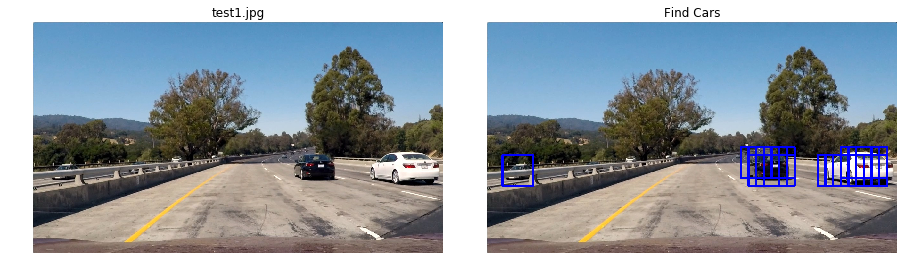

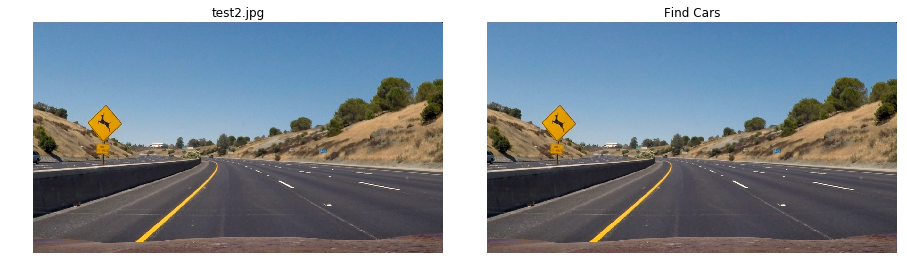

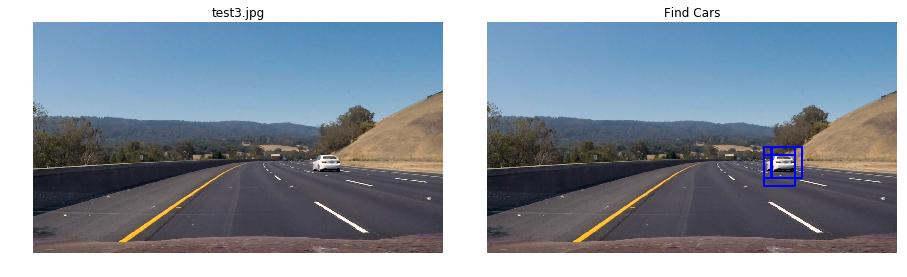

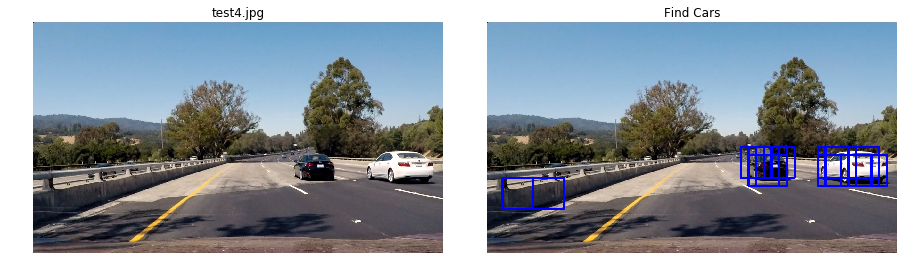

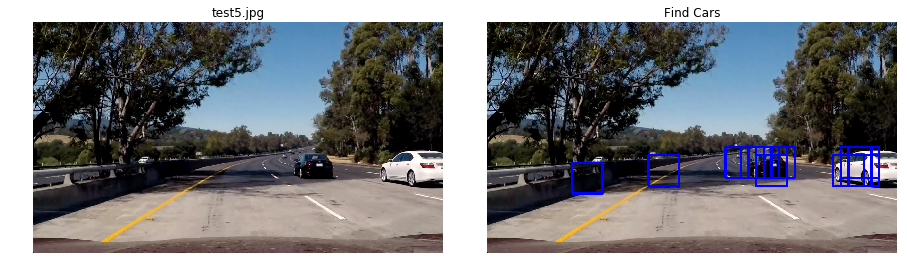

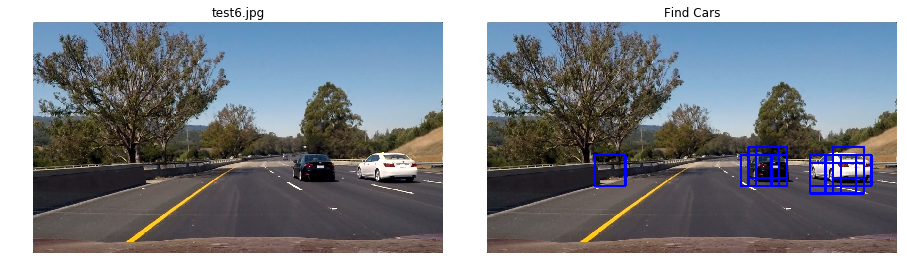

In [53]:
scale = 1.5

for filename in os.listdir(TEST_IMAGES_DIR):
    image = cv2.imread(TEST_IMAGES_DIR + filename)

    car_windows = find_cars(image, Y_BEGIN, Y_END, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    window_img = draw_boxes(image, car_windows, color=(0, 0, 255), thick=6)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,16))
    fig.tight_layout()
    ax[0].imshow(image)
    ax[0].set_title(filename)
    ax[0].set_axis_off()
    ax[1].imshow(window_img)
    ax[1].set_title('Find Cars')
    ax[1].set_axis_off()
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    plt.show()

In [ ]:
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

filenames = [("project_video.mp4", "project.mp4"), 
             ("test_video.mp4", "test.mp4")]

for infile, outfile in filenames:
    clip = VideoFileClip(infile)
    clip_processed = clip.fl_image(process_image)
    %time clip_processed.write_videofile(outfile, audio=False)

[MoviePy] >>>> Building video easy.mp4
[MoviePy] Writing video easy.mp4


100%|█████████▉| 1260/1261 [02:44<00:00,  7.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: easy.mp4 

CPU times: user 2min 49s, sys: 22 s, total: 3min 11s
Wall time: 2min 45s
[MoviePy] >>>> Building video hard.mp4
[MoviePy] Writing video hard.mp4


100%|██████████| 485/485 [01:03<00:00,  7.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: hard.mp4 

CPU times: user 1min 6s, sys: 8.53 s, total: 1min 15s
Wall time: 1min 4s
[MoviePy] >>>> Building video harder.mp4
[MoviePy] Writing video harder.mp4


100%|█████████▉| 1199/1200 [02:42<00:00,  7.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder.mp4 

CPU times: user 2min 47s, sys: 21.5 s, total: 3min 9s
Wall time: 2min 43s


In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
<video width="960" height="540" controls>
  <source src="{1}">
</video>
<video width="960" height="540" controls>
  <source src="{2}">
</video>
""".format(filenames[0][1], filenames[1][1], filenames[2][1]))